## Features para S&P 500

En lo que sigue se estudian las correlaciones entre los *candidatos* a features para el S&P 500. Todos han sido transformados a retornos lineales, según la definición:
$$
R = \frac{P_i - P_{i-1}}{P_{i-1}}
$$
Es importante destacar que los retornos no heredan la componente tendencial de las series originales, sin embargo, los indicadores técnicos sí poseerán dicha componente. De manera que, los indicadores técnicos poseen imformación para hacer predicciones a largo plazo.

Además cada feature es retrasado en un paso temporal, es decir, si la variable de clase, en este caso el signo del retorno del S&P 500, está en el tiempo $t_{i}$, los features deben estar en el tiempo $t_{i-1}$ para realizar predicciones en base a estos.

En la siguiente tabla se muestran estadísticas globales de los 37 *candidatos* a features y el retorno del S&P 500 (`Return_GSPC`). Las cuentas iguales en cada columna muestra que están no hay datos faltantes entre las respectivas columnas. La media (`mean`) y la desviación estándar (`std`), al igual que el mínimo, el máximo y los percentiles 25, 50 y 75, todos muestran que **los features no están en la misma escala y que por lo tanto es necesario normalizar restando la media y dividiendo por la desviación estándar**.

In [1]:
%pylab inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import itertools as it
import seaborn as sns

sns.set(context="notebook", style="ticks", palette="muted", color_codes=True)

In [3]:

# DATOS ORIGINALES DE MARI -----------------------------------------------------------------------------------------
# raw_data = pd.read_csv("../data/processed/filter-analysis/sp500-global.csv", index_col="Date")

# # sort and update index
# raw_data.sort_index(inplace=True)
# raw_data.index = pd.DatetimeIndex(raw_data.index)

# # store dropped columns
# to_drop = ["Year", "Month", "Day", "class"]
# dropped = raw_data.filter(items=to_drop)

# # actually drop columns
# X = raw_data.filter(like="lag1", axis=1)
# X.insert(0, "Return_GSPC", raw_data.Return_GSPC)
# ------------------------------------------------------------------------------------------------------------------

# use new datasets
X_raw = pd.read_csv("../data/processed/sp500-ml/features-raw.csv", index_col=0, parse_dates=True, header=[0, 1])
Y_raw = pd.read_csv("../data/processed/sp500-ml/target-raw.csv", index_col="Date", parse_dates=True)

X_raw.columns = X_raw.columns.droplevel("Type")

X = X_raw.copy()
Y = Y_raw.copy()

X.fillna(method="ffill", inplace=True)
X.dropna(how="all", axis="index", inplace=True)
Y = Y.reindex(index=X.index)
Y.dropna(how="all", axis="index", inplace=True)
X = X.reindex(index=Y.index)

### Un vistazo a los features

En el siguiente gráfico se observan las series temporales para los features. El color azul signo positivo en el retorno del S&P 500 y el rojo significa signo negativo. Ningún feature por sí mismo proporciona información para separar ambas clases, como es de esperarse. Sin embargo, los indicadores técnicos más similares al a definición del retorno, como el momento (`mom_lag1`) y el ROC (`roc_lag1`) se muestran como mejores opciones en este sentido. En lo que sigue se examinará más detalladamente el poder predictivo de estos candidatos a features.

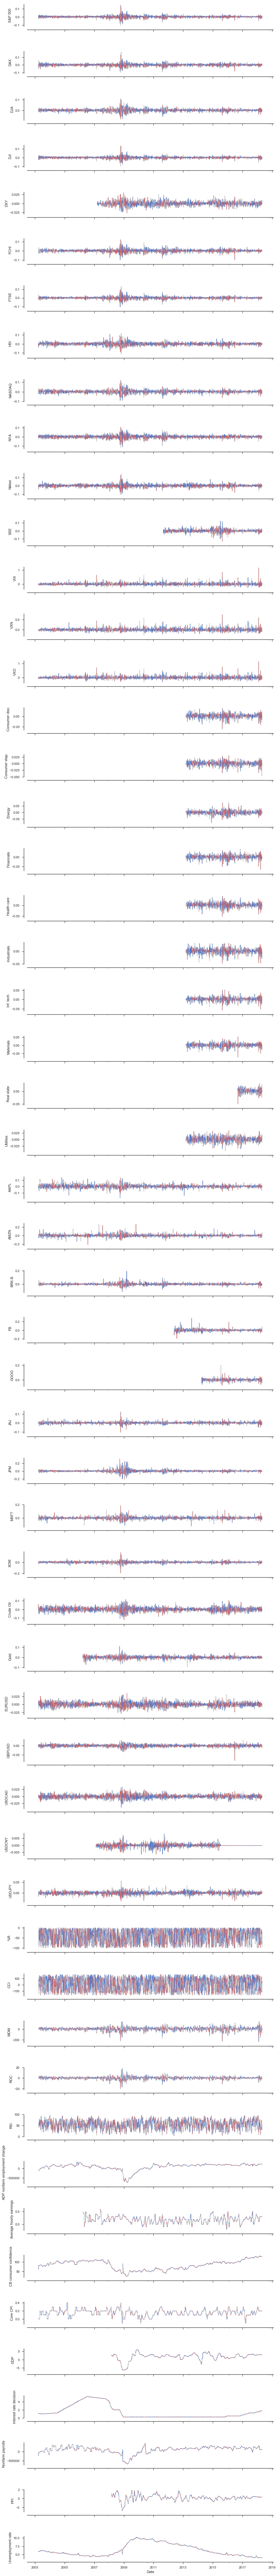

In [4]:
# display features
fig, axs = subplots(len(X.columns), sharex=True, figsize=(12, 2*len(X.columns)))

for j, column in enumerate(X.columns):
    axs[j].set_ylabel(column)
    series = X.get(column)
    up_return = series.mask(Y_raw.Class==0)
    dw_return = series.mask(Y_raw.Class==1)
    
    series.plot(ax=axs[j], style="-", color="0.8", lw=2)
    up_return.plot(ax=axs[j], style="-b", lw=1)
    dw_return.plot(ax=axs[j], style="-r", lw=1)
    
sns.despine(offset=10)
fig.tight_layout()
fig.savefig("../data/img/new-sp500-features.png")

In [5]:
X.describe(include="all")

Name       S&P 500          DAX          DJA          DJI          DXY  \
count  3943.000000  3944.000000  3944.000000  3944.000000  2920.000000   
mean      0.000345     0.000530     0.000460     0.000329     0.000107   
std       0.011379     0.014023     0.011699     0.010567     0.006095   
min      -0.106233    -0.098862    -0.083277    -0.097799    -0.026803   
25%      -0.003873    -0.005448    -0.004623    -0.003707    -0.003224   
50%       0.000621     0.000927     0.000751     0.000523     0.000000   
75%       0.005167     0.007065     0.006036     0.004936     0.003199   
max       0.142583     0.171025     0.106156     0.134354     0.030288   

Name          FCHI         FTSE          HSI       NASDAQ          NYA  \
count  3941.000000  3944.000000  3944.000000  3944.000000  3944.000000   
mean      0.000284     0.000283     0.000505     0.000668     0.000505   
std       0.013959     0.012052     0.014893     0.013669     0.014743   
min      -0.101024    -0.104726    -0.109642    -0.091424    -0.118118   
25%      -0.005972    -0.004540    -0.006355    -0.005164    -0.006438   
50%       0.000504     0.000364     0.000620     0.001216     0.000995   
75%       0.006913     0.005505     0.007799     0.007334     0.007969   
max       0.123582     0.133163     0.117871     0.118059     0.106267   

Name         ...                  RSI  ADP nonfarm employment change  \
count        ...          3939.000000                    3944.000000   
mean         ...            55.763972                  102949.391990   
std          ...            19.468238                  176786.404078   
min          ...             3.772528                 -742000.000000   
25%          ...            41.556755                   59000.000000   
50%          ...            57.401440                  160655.172414   
75%          ...            71.056648                  202428.571429   
max          ...            96.517540                  343000.000000   

Name   Average hourly earnings  CB consumer confidence     Core CPI  \
count              3169.000000             3944.000000  3944.000000   
mean                  0.182035               83.849753     0.159264   
std                   0.126419               23.686571     0.076337   
min                  -0.200000               25.000000    -0.100000   
25%                   0.100000               63.334821     0.100000   
50%                   0.192308               88.500000     0.168571   
75%                   0.275000              102.896667     0.200000   
max                   0.600000              130.800000     0.400000   

Name           GDP  Interest rate decision  Nonfarm payrolls          PPI  \
count  2675.000000             3944.000000       3944.000000  2677.000000   
mean      1.753218                1.392224     100205.698147     0.152902   
std       2.095871                1.611005     181595.789573     0.615688   
min      -6.300000                0.250000    -663000.000000    -2.800000   
25%       1.185961                0.250000      41439.285714    -0.109091   
50%       2.148485                0.500000     150571.428571     0.178571   
75%       2.900000                2.000000     209310.344828     0.400000   
max       5.900000                5.250000     431000.000000     1.800000   

Name   Unemployment rate  
count        3944.000000  
mean            6.354752  
std             1.804390  
min             4.100000  
25%             4.900000  
50%             5.645902  
75%             7.885714  
max            10.200000  

[8 rows x 55 columns]

### Análisis de correlaciones

Una forma de estudiar el poder predictivo de los *candidatos* a features, que ha quedado en duda con los experimentos realizados en Azure ML, es revisando las correlaciones entre los mismos con la variable de clase y con ellos mismos. Ya que no en los experimentos en Azure se vió que no existen correlaciones fuertes entre la variable de clase y los features, de manera global, a continuación se hará un estudio más detallado al respecto.

Para esto tomamos cada serie temporal y la bineamos en intervalos de una semana laboral (5 días). En cada bin se calculará la correlación que existe entre la variable de clase y los features y entre features y features. El umbral para decidir si una correlación con la variable de clase es relevante será 0.2. Una correlación entre features se considerará relevante si es mayor que 0.3 y se buscará que la selección final de features tengan correlaciones entre sí menores que esta cantidad para eliminar información redundante.

Se procede a calcular las correlaciones bineadas de la siguiente forma:

In [6]:
CLASS_THRESHOLD = 0.2
OTHER_THRESHOLD = 0.3

# compute bins
bins = pd.cut(X.index, bins=X.index[::5])

# correlations with GSPC
gr = X.groupby(bins)
corr_with_class_bins = gr.corrwith(Y.Class)
corr_with_class_stat = corr_with_class_bins.agg(["median", "mean"])
corr_with_class_stat = corr_with_class_stat.transpose()

# filter columns by correlation
filtered_columns = X.columns[np.abs(corr_with_class_stat["median"]) > CLASS_THRESHOLD]
X = X.filter(items=filtered_columns, axis="columns")
X.insert(loc=X.columns.size, column="Class", value=Y.Class)

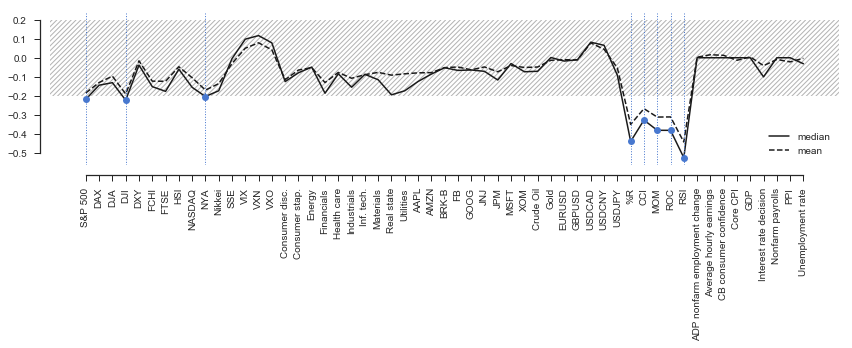

In [7]:
# plot results
xvals = arange(corr_with_class_stat.index.size)
fig, ax = subplots(1, 1, figsize=(12,5))
corr_with_class_stat.plot(x=xvals, ax=ax, lw=1.5, style=["k-", "k--"])
ax.axhspan(-CLASS_THRESHOLD, +CLASS_THRESHOLD, color="0.7", fc="none", hatch="/////", lw=0.0)
for i in xrange(xvals.size):
    if corr_with_class_stat.index[i] in filtered_columns:
        ax.axvline(xvals[i], ls=":", lw=1, color="b")
        ax.plot(xvals[i], corr_with_class_stat["median"][i], "ob", mew=0, ms=7)
ax.set_xticks(xvals)
sns.despine(offset=10, trim=True)
ax.set_xticklabels(corr_with_class_stat.index.values, rotation=90)
fig.tight_layout()
fig.savefig("../data/img/new-sp500-feature-correlations.png")

Una vez calculados los bines de correlación con la variable de clase (`corr_with_class_bins`) se calculan las estadísticas: media, mediana y desviación estándar. Estas darán una idea global de los features que estamos considerando relevantes en este ejercicio. En el gráfico anterior se muestran los features fuera de la región sombreada como relevantes de acuerdo a nuestro criterio. Las líneas rojas representan los features relevantes.

A continuación se usarán estos features para estudiar las correlaciones entre sí y verificar cuales ofrecen la misma información y cuales no.

In [8]:
# correlations with eachother
gr = X.groupby(bins)
corr_with_other_bins = gr.corr()
corr_with_other_bins.index.names = ["Daterange", "Symbol"]
corr_with_other_stat = corr_with_other_bins.groupby(level="Symbol", sort=False)

#### Correlaciones entre los features

En los paneles de abajo se aprecian las correlaciones entre los distintos features y la variable de clase como función de los bines temporales calculados anteriormente. Antes de describir los comportamientos observados, se describirá lo que se espera en el mejor de los casos:

1. En el caso de las correlaciones con la variable de clase, las series deberían estar en valores extremos de las distribuciones de correlación, es decir, en valores cercanos a +/-1.
2. En el caso de las correlaciones entre los features, lo que se espera es lo contrario, que las series se concentren en valores cercanos a 0, de manera que los features sean independientes entre sí y la información para la predicción no sea redundante.

En los gráficos estas regiones de comodidad se representan en gris. Estadísticamente la distribución de correlaciones de las series se presentan en azul. Lo ideal sería que las regiones azules se solaparan con las regiones grises, sin embargo esta no es la norma en los gráficos. En resumidas cuentas los features que se presentan como candidatos no son los mejores para una predicción. Aún así una conclusión interesante y positiva se puede derivar de estos resultados: **los features relevantes para la predicción del S&P 500 son función del tiempo**.

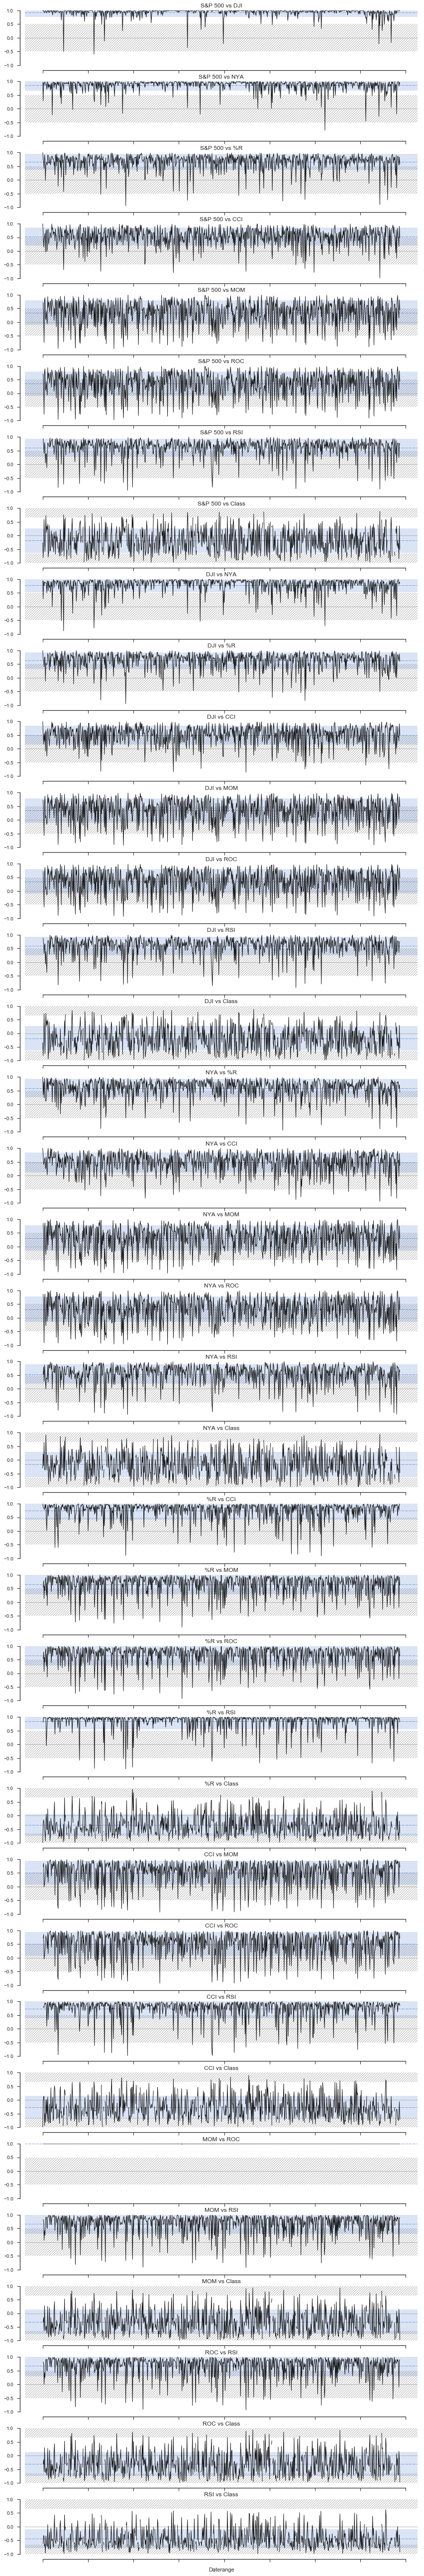

In [9]:
idx = pd.IndexSlice
com = list(it.combinations(corr_with_other_bins.columns.values, 2))

fig, axs = subplots(len(com), sharex=True, sharey=True, figsize=(12, 2*len(com)))
axs[0].set_ylim(-1, +1)

for k, (name_i, name_j) in enumerate(com):
    series = corr_with_other_bins.loc[idx[:,name_i], name_j]
    series.index = series.index.droplevel("Symbol")
    
    axs[k].set_title("{} vs {}".format(name_i, name_j))
    axs[k].axhline(ls="-", color="0.7", lw=1)
    
    if "Class" in [name_i, name_j]:
        axs[k].axhspan(+0.65, +1.0, hatch="/////", facecolor="none", edgecolor="0.7", lw=0)
        axs[k].axhspan(-0.65, -1.0, hatch="/////", facecolor="none", edgecolor="0.7", lw=0)
    else:
        axs[k].axhspan(-0.5, +0.5, hatch="/////", facecolor="none", edgecolor="0.7", lw=0)
    
    mean, std = series.mean(), series.std()
    axs[k].axhspan(mean-std, mean+std, facecolor="b", alpha=0.2, lw=0)
    axs[k].axhline(mean, ls="-.", color="b", lw=0.7)
    
    series.plot(x=series.index, ax=axs[k], style="k-", lw=1)

sns.despine(offset=10, trim=True)
fig.tight_layout()
fig.savefig("../data/img/new-sp500-feature-correlations-series.png", bbox_inches="tight")

En los siguientes gráficos se muestran las series colapsadas en el tiempo, es decir las distribuciones de las correlaciones, al igual que los rangos deseados (en gris) y los encontrados (azul).

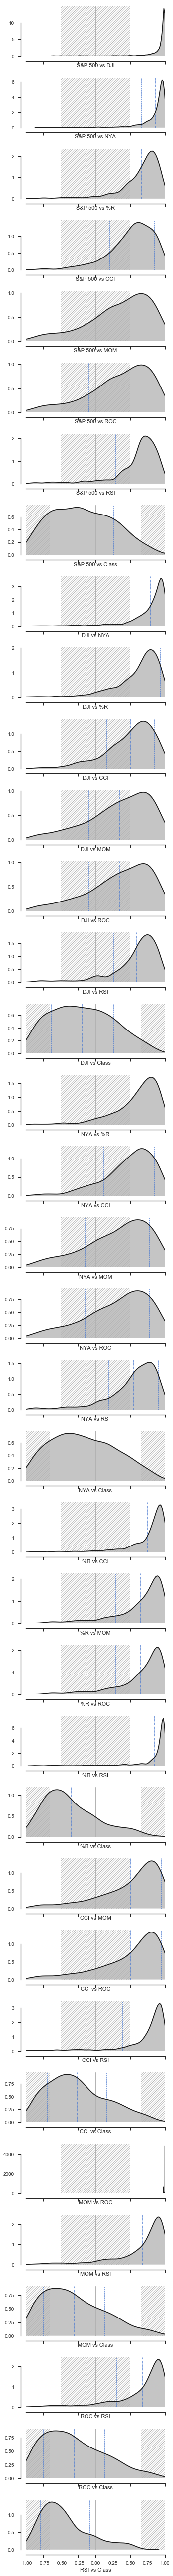

In [10]:
idx = pd.IndexSlice
com = list(it.combinations(corr_with_other_bins.columns.values, 2))

fig, axs = subplots(len(com), sharex=True, figsize=(5, 2*len(com)))
axs[k].set_xlim(-1, +1)

for k, (name_i, name_j) in enumerate(com):
    series = corr_with_other_bins.loc[idx[:,name_i], name_j]
    series.index = series.index.droplevel("Symbol")
    
    axs[k].set_xlabel("{} vs {}".format(name_i, name_j))
    axs[k].axvline(ls="-", color="0.7", lw=1)
    
    if "Class" in [name_i, name_j]:
        axs[k].axvspan(+0.65, +1.0, hatch="/////", facecolor="none", edgecolor="0.7", lw=0)
        axs[k].axvspan(-0.65, -1.0, hatch="/////", facecolor="none", edgecolor="0.7", lw=0)
    else:
        axs[k].axvspan(-0.5, +0.5, hatch="/////", facecolor="none", edgecolor="0.7", lw=0)
    
    mean, std = series.mean(), series.std()
    axs[k].axvline(mean-std, ls="--", color="b", lw=0.7)
    axs[k].axvline(mean+std, ls="--", color="b", lw=0.7)
    axs[k].axvline(mean, ls="-.", color="b", lw=0.7)
    
    sns.kdeplot(series, color="k", ax=axs[k], shade=True, legend=False)

sns.despine(offset=10, trim=True)
fig.tight_layout()
fig.savefig("../data/img/new-sp500-feature-correlations-histograms.png", bbox_inches="tight")

### Conclusiones

El resultado más interesante de este ejercicio es que el conjunto de mejores features es función del tiempo. Esto complica un poco el panorama. Una posible solución al problema adicional de variar los features es usar un modelo de ML más flexible. Redes Neuronales podría ser la clave ya que si se introducen varias capas ocultas (como en deep learning) en principio no sería necesario filtrar los features porque el modelo tiene la capacidad de *aprender* qué features son los que proporcionan el mayor poder predictivo (esto tengo que confirmarlo aún, pero lo leí en algún lado). Otra solución más terrenal es usar un arbol de decisión para filtrar los features en el momento de la predicción, es decir, una vez los datos de todos los features han sido publicados, usar un arbol de desiciones entredado específicamente para decidir qué features son los mejores, luego usar un modelo específicamente entrenado para la predicción con esos features. Lo último es la parte complicada porque una vez un modelo ha sido entrenado con un conjunto de features, solo esos features espera para hacer predicciones. Habrá que investigar si esto es así en todos los casos o si existen modelos lo suficientemente flexibles como para permitir entradas variables.

### Apéndice

En el siguiente gráfico se muestra un resumen del panorama con estos features. En verde y azul se presentan las distribuciones de subidas y bajadas en la variable de clase. Es claro nuevamente que ningún feature es capaz de separar de manera unívoca o incluso parcialmente estas clases.

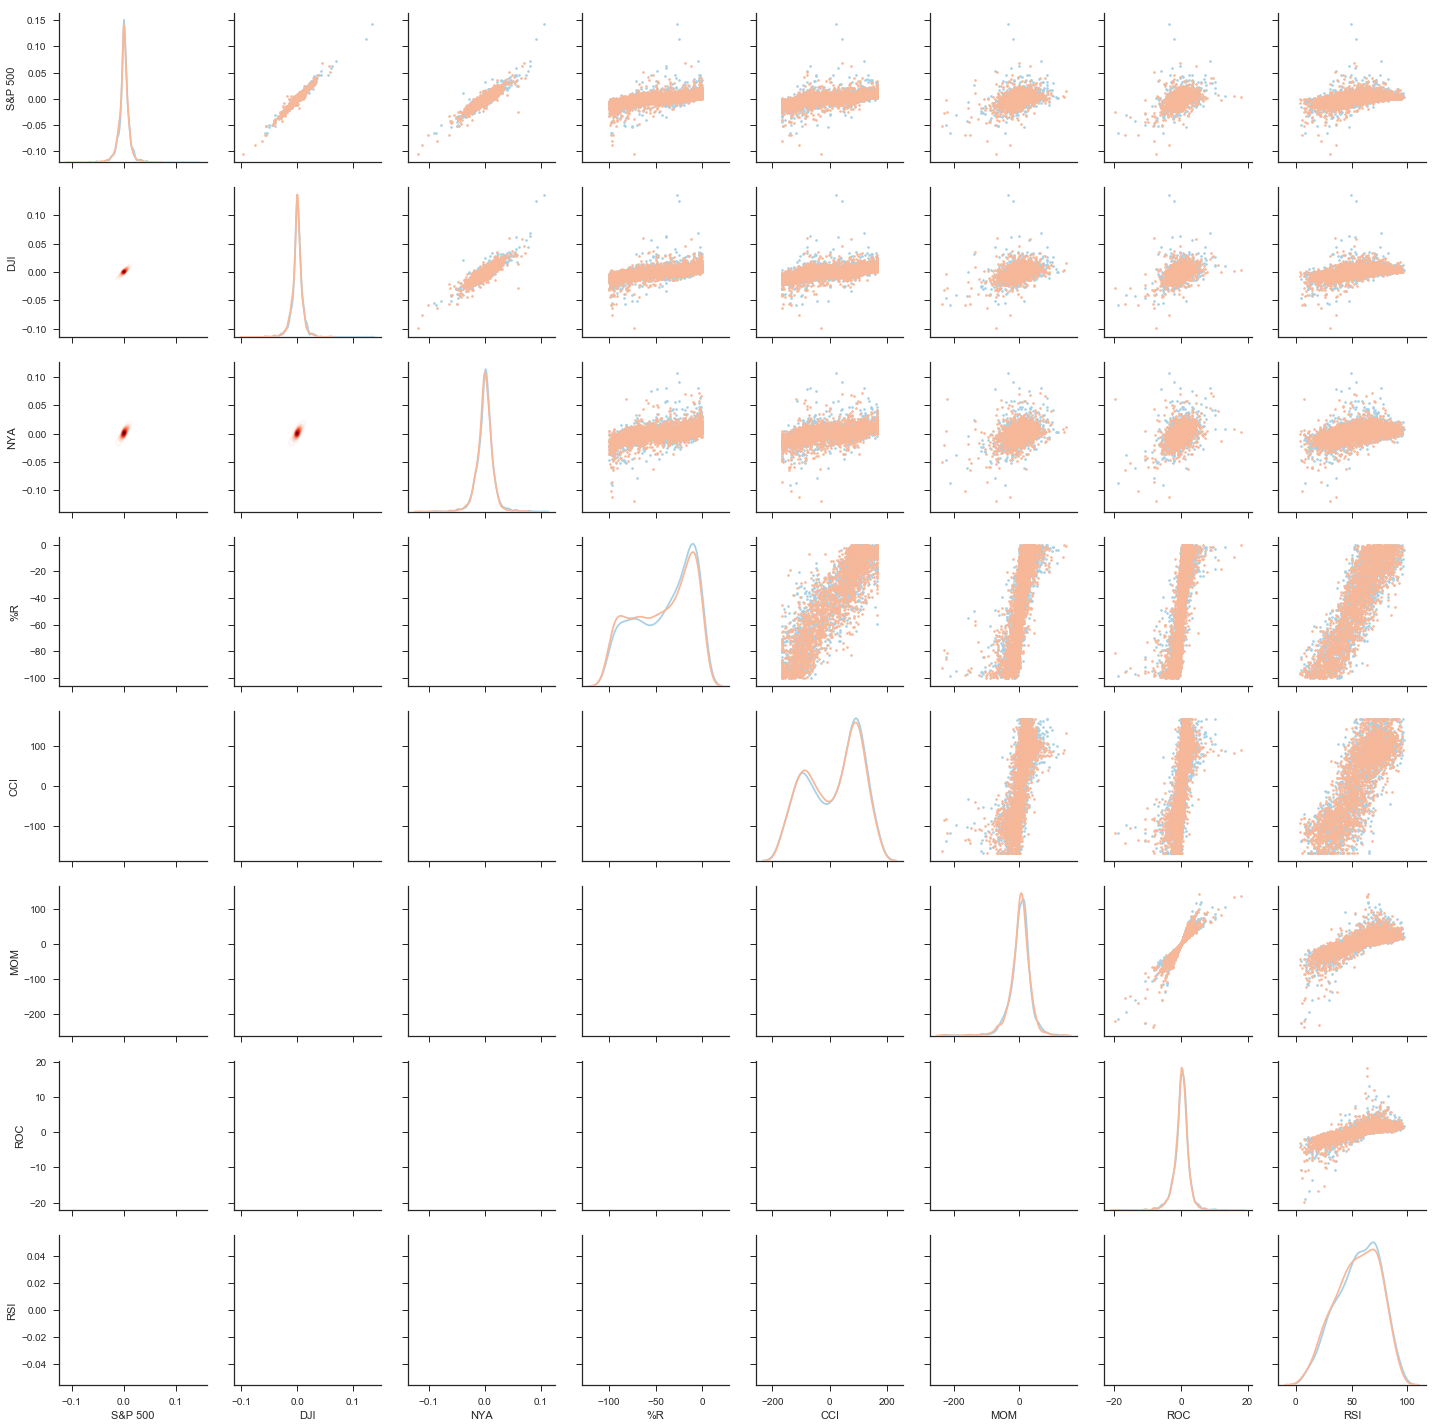

In [11]:
g = sns.PairGrid(X, diag_sharey=False, hue="Class", palette="RdBu_r", hue_kws={"cmap": ["Blues", "Reds"]}, vars=X.columns.delete(loc=X.columns.size-1))
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter, s=7, lw=0)
g.map_diag(sns.kdeplot)
g.savefig("../data/img/new-sp500-features-predictability.png")